<a href="https://colab.research.google.com/github/AnthonyAugust/Projetos-Finalizados/blob/Projetos-Finalizados/Transfer_Learning_C%C3%A3es_e_Gatos_(Antonio_Augusto).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

# Projeto de Transfer Learning em Python

In [1]:
#Extraindo o arquivo ZIP
import zipfile
import os

zip_path = "/content/kagglecatsanddogs_5340.zip"  # caminho do seu arquivo zipado
extract_path = "/content/kagglecatsanddogs_5340"  # pasta destino

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extração concluída!")
os.listdir(extract_path)

Extração concluída!


['PetImages', 'CDLA-Permissive-2.0.pdf', 'readme[1].txt']

In [2]:
#Removendo Arquivos Corrompidos
import os
from PIL import Image

image_dir = "/content/kagglecatsanddogs_5340/PetImages"

num_removed = 0

for folder in ["Cat", "Dog"]:
    folder_path = os.path.join(image_dir, folder)
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        try:
            # Abre e verifica se a imagem é válida
            img = Image.open(file_path)
            img.verify()
        except (IOError, SyntaxError):
            os.remove(file_path)
            num_removed += 1

print(f"Arquivos removidos: {num_removed}")

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Arquivos removidos: 4


In [3]:
#Garantindo que o tensor flow pode ler os arquivos depois da limpeza
import tensorflow as tf

def validate_images(directory):
    num_errors = 0
    for folder in ["Cat", "Dog"]:
        folder_path = os.path.join(directory, folder)
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            try:
                image_data = tf.io.read_file(file_path)
                img = tf.image.decode_image(image_data)
            except tf.errors.InvalidArgumentError:
                print(f"Imagem inválida detectada e removida: {file_path}")
                os.remove(file_path)
                num_errors += 1
    print(f"Total de imagens removidas no passo TensorFlow: {num_errors}")

validate_images(image_dir)

Imagem inválida detectada e removida: /content/kagglecatsanddogs_5340/PetImages/Cat/10404.jpg
Imagem inválida detectada e removida: /content/kagglecatsanddogs_5340/PetImages/Cat/4351.jpg
Imagem inválida detectada e removida: /content/kagglecatsanddogs_5340/PetImages/Dog/2494.jpg
Imagem inválida detectada e removida: /content/kagglecatsanddogs_5340/PetImages/Dog/11912.jpg
Imagem inválida detectada e removida: /content/kagglecatsanddogs_5340/PetImages/Dog/11233.jpg
Imagem inválida detectada e removida: /content/kagglecatsanddogs_5340/PetImages/Dog/9500.jpg
Imagem inválida detectada e removida: /content/kagglecatsanddogs_5340/PetImages/Dog/2317.jpg
Total de imagens removidas no passo TensorFlow: 7


In [4]:
#Bibliotecas
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import pathlib
import os
from PIL import Image

data_dir = pathlib.Path("/content/kagglecatsanddogs_5340/PetImages")

#Parâmetros
batch_size = 32
img_height = 160
img_width = 160
#Conjunto de treinos e validação
train_ds = tf.keras.utils.image_dataset_from_directory(
    image_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    image_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 24991 files belonging to 2 classes.
Using 19993 files for training.
Found 24991 files belonging to 2 classes.
Using 4998 files for validation.


In [5]:
#Normalização do Modelo
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Otimização de performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [6]:
#Carregando o modelo pré-treinado(MobileNetV2)
base_model = tf.keras.applications.MobileNetV2(input_shape=(img_height, img_width, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False  # Congelar as camadas

In [7]:
#Adicionando Camadas Finas
global_avg_pool = layers.GlobalAveragePooling2D()(base_model.output)
output_layer = layers.Dense(1, activation='sigmoid')(global_avg_pool)

model = models.Model(inputs=base_model.input, outputs=output_layer)

In [8]:
#Compilando o modelo
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [9]:
#Treinando o modelo
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 488s 732ms/step - accuracy: 0.8700 - loss: 0.3429 - val_accuracy: 0.9626 - val_loss: 0.1294
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 492s 788ms/step - accuracy: 0.9636 - loss: 0.1113 - val_accuracy: 0.9696 - val_loss: 0.0964
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 461s 723ms/step - accuracy: 0.9713 - loss: 0.0836 - val_accuracy: 0.9722 - val_loss: 0.0841
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 447s 716ms/step - accuracy: 0.9742 - loss: 0.0739 - val_accuracy: 0.9732 - val_loss: 0.0779
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 448s 716ms/step - accuracy: 0.9757 - loss: 0.0687 - val_accuracy: 0.9742 - val_loss: 0.0742


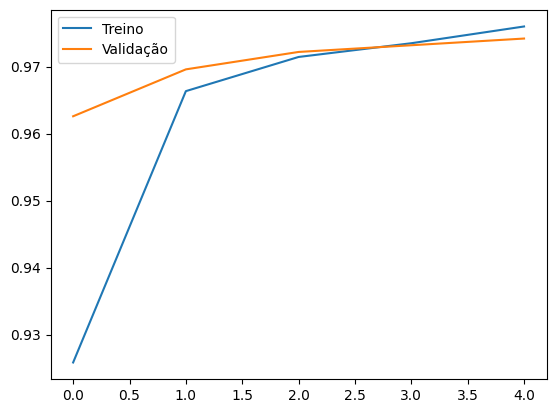

In [10]:
#Plotando resultados
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.legend()
plt.show()

In [11]:
#Salvando o modelo
model.save("/content/transfer_learning_cats_dogs.h5")